<center><h3> News Tweet Analysis </h3> 
Sita Robinson, Nick Santini, Abdelrahman Salem</center>

In [4]:
import twitter
import json
import tweepy
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [5]:
def oauth_login():
    # Twitter App Credentials
    CONSUMER_KEY = 'rU2DgtkQVDmxsxiM0UqOq39Tk'
    CONSUMER_SECRET = 'jPBVLlJVtLKqZpKDRX34Dlj7UEqEzNsLH3Qxd1SihWtZtnKBms'
    OAUTH_TOKEN = '1722919758-1r0sZmPrTKO83MwkvE7hGmMKsiXkD76EiXl3Ctb'
    OAUTH_TOKEN_SECRET = 'FG0P91BaA6nM2a0oZWemDvbpSj0lhL6EOGl40De1RSqma'
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    
    api = tweepy.API(auth)
    return api

# Create API object
api = oauth_login()  
print(api)

In [8]:
#Search for English tweets with hashtag 'news'
tweets = api.search('#news -filter:retweets', lang='en', count=200)
for item in tweets:
    if item.lang == "en":
        if (not item.retweeted) and ('RT @' not in item.text) and (item.favorite_count > 0):
            print (item.text)

data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

display(data.head(10))
print("Latest tweet recorded at:")
print(tweets[0].created_at)

Dont roar at me you big cat

Read more: https://t.co/hZjIhLd50R

#funny #meme #facts #news #viral #trending… https://t.co/RlIUUbyrCQ
Transfer #news and rumours LIVE: Barca worried Liverpool could poach De https://t.co/zjdYENrOFq
#FortunaSittard 🇳🇱… https://t.co/HXuDxCEnPK
Ooh how exciting thank you @iafdcom for my #SpankBank Award nomination 

• Sage of 69 - Tanya Tate

#Awards… https://t.co/kQfBfmhKIh


,Tweets
0,Bitcoin Was Worth 46 Percent In A Month And Ra...
1,Speed limit on Mass. Pike reduced to 40 MPH fr...
2,Kodak Black arrested at Rolling Loud Music Fes...
3,Dont roar at me you big cat\n\nRead more: http...
4,Did Jordyn Woods Give This Part Of Her Life A ...
5,"Canadian Music Week 2019: Triumph, Loud Luxury..."
6,"Rapper Kodak Black arrested, Lil Wayne searche..."
7,Country Music Star Brad Paisley Headlines Key ...
8,Chloe likes music and dancing https://t.co/o4f...
9,High Five Lollie Letter Sign up: https://t.co/...


Latest tweet recorded at:
2019-05-12 22:23:38


In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

TODO: Save to Mongo DB

<center><h3>Sentiment Analysis</h3></center>

In [19]:
sid = SentimentIntensityAnalyzer()
storagepos = []
storageneg = []
storageneu = []
storagecomp=[]
for index, row in data.iterrows():
    ng = sid.polarity_scores(row["Tweets"])['neg']
    storageneg.append(ng)
    pos = sid.polarity_scores(row["Tweets"])['pos']
    storagepos.append(pos)
    neu = sid.polarity_scores(row["Tweets"])['neu']
    storageneu.append(neu)
    cp = sid.polarity_scores(row["Tweets"])['compound']
    storagecomp.append(cp)

negstorage = pd.Series(storageneg)
data['neg polarity'] = negstorage.values
posstorage = pd.Series(storagepos)
data['pos polarity'] = posstorage.values 
neustorage = pd.Series(storageneu)
data['neu polarity'] = neustorage.values
compstorage = pd.Series(storagecomp)
data['compound'] = compstorage.values

display(data.head(100))

,Tweets,neg polarity,pos polarity,neu polarity,compound
0,Bitcoin Was Worth 46 Percent In A Month And Ra...,0.000,0.101,0.899,0.2263
1,Speed limit on Mass. Pike reduced to 40 MPH fr...,0.000,0.000,1.000,0.0000
2,Kodak Black arrested at Rolling Loud Music Fes...,0.203,0.209,0.588,0.0258
3,Dont roar at me you big cat\n\nRead more: http...,0.000,0.000,1.000,0.0000
4,Did Jordyn Woods Give This Part Of Her Life A ...,0.130,0.000,0.870,-0.3400
5,"Canadian Music Week 2019: Triumph, Loud Luxury...",0.000,0.310,0.690,0.8016
6,"Rapper Kodak Black arrested, Lil Wayne searche...",0.153,0.158,0.690,0.0258
7,Country Music Star Brad Paisley Headlines Key ...,0.000,0.000,1.000,0.0000
8,Chloe likes music and dancing https://t.co/o4f...,0.000,0.286,0.714,0.4215
9,High Five Lollie Letter Sign up: https://t.co/...,0.000,0.000,1.000,0.0000


<center><h4> Histogram of Sentiments</h4></center>

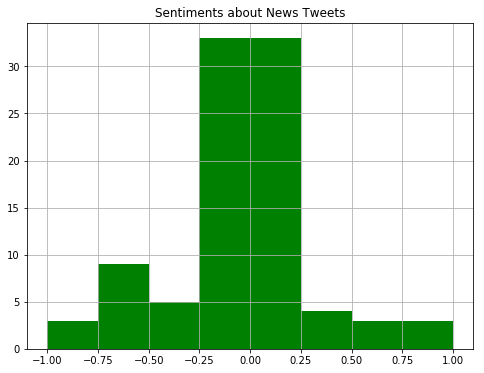

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
data['compound'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="green")

plt.title("Sentiments about News Tweets")
plt.show()

Looking at this histogram there seems to be in general more neutral and negative sentement in tweets than positive as to be expected.

<center><h3> What news are people mainly talking about?</h3></center>

Positive words


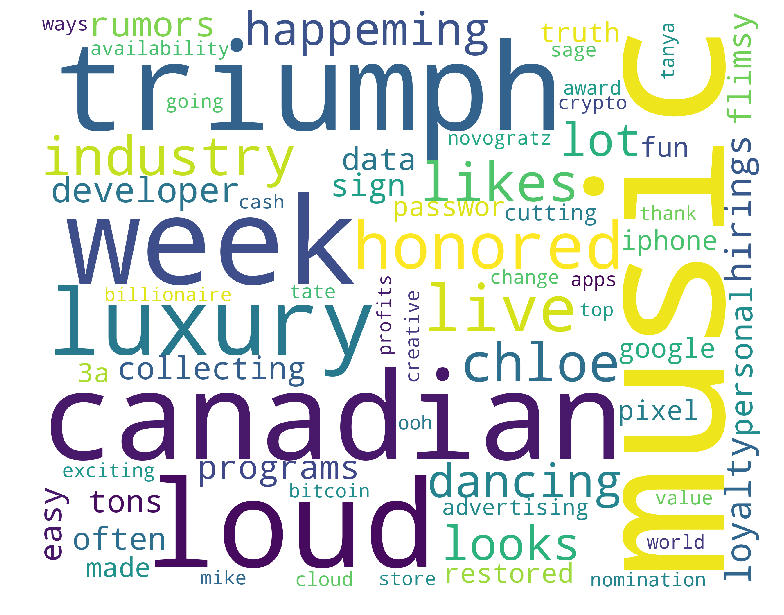

Negative words


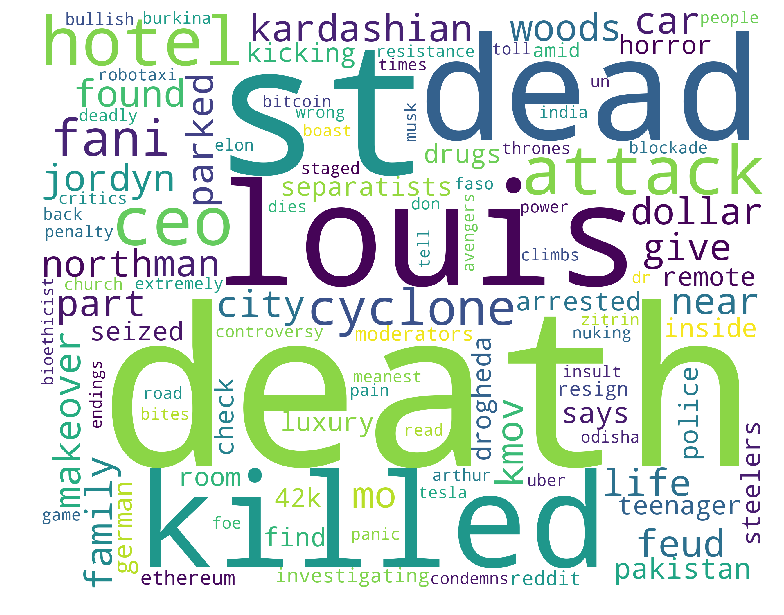

In [22]:
pos = data[data['compound']> 0.3]
pos = pos['Tweets']
neg = data[data['compound']< -0.3]
neg = neg['Tweets']
def wordcloud_draw(data):
    words = ' '.join(data)
    cleaned_word = " ".join([word.lower() for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT' 
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(pos)
print("Negative words")
wordcloud_draw(neg)

Overall Wordcloud

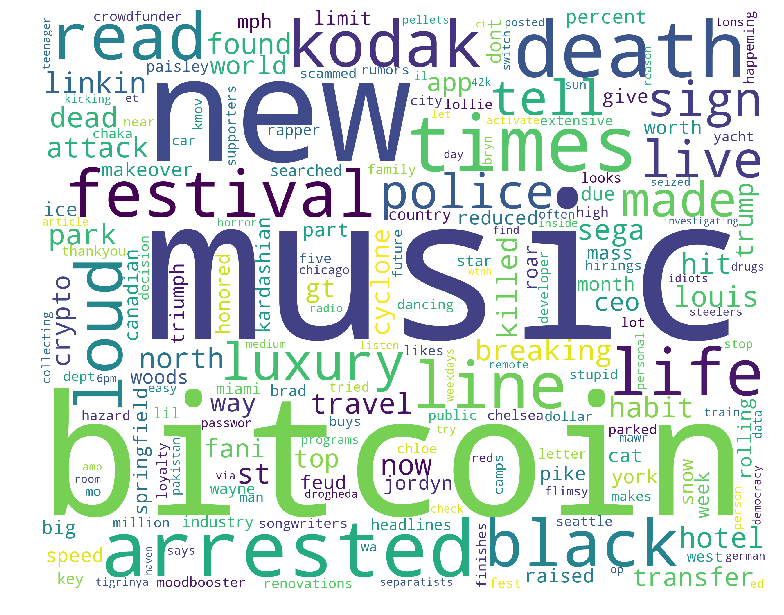

In [24]:
wordcloud_draw(data['Tweets'])